In [1]:
from google.colab import drive
drive.mount('/content/drive')
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, GRU

Mounted at /content/drive


In [2]:
# Đọc file csv
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Data/pre_DOGE-USD.csv')
df = df.rename(columns={'Close': 'Price'})
df['Date'] = pd.to_datetime(df['Date'])
df.head(5)

,Date,Open,High,Low,Price,Adj Close,Volume
0,2018-03-01,0.006042,0.006320,0.005945,0.006215,0.006215,15518400
1,2018-03-02,0.006174,0.006232,0.005447,0.005482,0.005482,22498100
2,2018-03-03,0.005494,0.005756,0.005181,0.005301,0.005301,21545000
3,2018-03-04,0.005234,0.005502,0.005164,0.005502,0.005502,12133500
4,2018-03-05,0.005462,0.005535,0.005157,0.005218,0.005218,13627700


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2285 entries, 0 to 2284
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   Date       2285 non-null   datetime64[ns]
 1   Open       2285 non-null   float64       
 2   High       2285 non-null   float64       
 3   Low        2285 non-null   float64       
 4   Price      2285 non-null   float64       
 5   Adj Close  2285 non-null   float64       
 6   Volume     2285 non-null   int64         
dtypes: datetime64[ns](1), float64(5), int64(1)
memory usage: 125.1 KB


In [4]:
# Thiết lập index
df1=df.reset_index()['Price']


In [5]:
# Scaler data
scaler=MinMaxScaler(feature_range=(0,1))
df1=scaler.fit_transform(np.array(df1).reshape(-1,1))

In [6]:
# Chia train test
train_size= int(0.8 * len(df1))
test_size = len(df1) - train_size

train_data = df1[:train_size]
test_data = df1[train_size:]

In [7]:
# convert an array of values into a dataset matrix
def create_dataset(dataset, time_step=1):
	dataX, dataY = [], []
	for i in range(len(dataset) - time_step - 1):
		a = dataset[i:(i + time_step)]
		dataX.append(a)
		dataY.append(dataset[i + time_step])
	return np.array(dataX), np.array(dataY)


In [8]:
# Reshape into X=t,t+1,t+2..t+99 and Y=t+100 _8_2
time_step = 100
X_train, y_train = create_dataset(train_data, time_step)
combined_data = np.concatenate((train_data[-time_step:], test_data))
X_test, y_test = create_dataset(combined_data, time_step)

# Reshape dữ liệu cho phù hợp với mạng GRU
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

In [9]:
# Define GRU Model

model = Sequential()
model.add(GRU(64, input_shape=(time_step, 1)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mean_squared_error')

In [10]:
# 9. Fit mô hình với dữ liệu train
model.fit(X_train, y_train, epochs=100, batch_size=64, verbose=1)

Epoch 1/100
27/27 [==============================] - 5s 83ms/step - loss: 0.0164
Epoch 2/100
27/27 [==============================] - 2s 84ms/step - loss: 0.0011
Epoch 3/100
27/27 [==============================] - 2s 65ms/step - loss: 7.7201e-04
Epoch 4/100
27/27 [==============================] - 2s 81ms/step - loss: 7.5423e-04
Epoch 5/100
27/27 [==============================] - 3s 104ms/step - loss: 6.9694e-04
Epoch 6/100
27/27 [==============================] - 3s 97ms/step - loss: 6.5432e-04
Epoch 7/100
27/27 [==============================] - 3s 129ms/step - loss: 6.7394e-04
Epoch 8/100
27/27 [==============================] - 4s 131ms/step - loss: 6.0720e-04
Epoch 9/100
27/27 [==============================] - 3s 128ms/step - loss: 5.9056e-04
Epoch 10/100
27/27 [==============================] - 2s 76ms/step - loss: 5.3964e-04
Epoch 11/100
27/27 [==============================] - 1s 51ms/step - loss: 5.1949e-04
Epoch 12/100
27/27 [==============================] - 1s 52ms/step 

In [11]:
# Dự báo dữ liệu test và train
train_predict = model.predict(X_train)
y_pred = model.predict(X_test)

15/15 [==============================] - 0s 18ms/step


In [12]:
# Chuẩn hóa dữ liệu y_pred
train_predict = scaler.inverse_transform(train_predict)
y_pred = scaler.inverse_transform(y_pred)

In [13]:
# Dự báo 90 ngày tiếp theo
x_input = test_data[-100:].reshape(1, -1)
temp_input = list(x_input[0])
lst_output = []

i = 0
while(i < 90):
    if len(temp_input) > 100:
        x_input = np.array(temp_input[1:])  # Lấy từng ngày từ ngày thứ 2 trở đi
        x_input = x_input.reshape(1, time_step, 1)  # Reshape lại để phù hợp với input của mạng
        yhat = model.predict(x_input, verbose=0)  # Dự đoán giá cho ngày tiếp theo
        temp_input.extend(yhat[0].tolist())  # Thêm dự đoán vào danh sách temp_input
        temp_input = temp_input[1:]  # Loại bỏ ngày đầu tiên
        lst_output.extend(yhat.tolist())  # Lưu dự đoán vào mảng lst_output
        i += 1
    else:
        x_input = x_input.reshape(1, time_step, 1)  # Reshape lại để phù hợp với input của mạng
        yhat = model.predict(x_input, verbose=0)  # Dự đoán giá cho ngày tiếp theo
        temp_input.extend(yhat[0].tolist())  # Thêm dự đoán vào danh sách temp_input
        lst_output.extend(yhat.tolist())  # Lưu dự đoán vào mảng lst_output
        i += 1

# In ra dự đoán cho 90 ngày tiếp theo
print("Dự đoán giá cho 90 ngày tiếp theo:")
print(lst_output)

Dự đoán giá cho 90 ngày tiếp theo:
[[0.23700934648513794], [0.24242454767227173], [0.249489426612854], [0.257257878780365], [0.2649683952331543], [0.27222228050231934], [0.2789361774921417], [0.28522196412086487], [0.29126280546188354], [0.297222763299942], [0.3032020628452301], [0.30923157930374146], [0.31529200077056885], [0.3213401734828949], [0.327332079410553], [0.33323585987091064], [0.3390360474586487], [0.34473055601119995], [0.350324809551239], [0.35582587122917175], [0.36123862862586975], [0.36656463146209717], [0.37180188298225403], [0.37694692611694336], [0.38199561834335327], [0.3869447410106659], [0.3917921185493469], [0.3965367376804352], [0.4011785089969635], [0.40571749210357666], [0.410153865814209], [0.41448795795440674], [0.4187195599079132], [0.42284896969795227], [0.4268761873245239], [0.4308016300201416], [0.4346257448196411], [0.4383496344089508], [0.44197380542755127], [0.4454996883869171], [0.44892826676368713], [0.4522608518600464], [0.45549869537353516], [0.

In [14]:
predict_future_30 = lst_output[:30]
predict_future_60 = lst_output[30:60]
predict_future_90 = lst_output[60:]


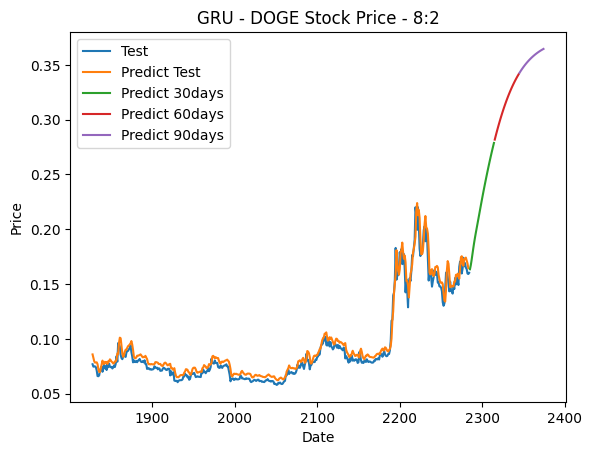

In [16]:
#Vẽ hình
# train_data_index = pd.RangeIndex(start=0, stop=len(train_data), step=1)
# plt.plot(train_data_index, scaler.inverse_transform(train_data), label='Train')

test_data_index = pd.RangeIndex(start=train_size, stop=train_size+len(test_data), step=1)
plt.plot(test_data_index, scaler.inverse_transform(test_data), label='Test')

predicted_test_index = pd.RangeIndex(start=train_size, stop=train_size+len(y_pred), step=1)
plt.plot(predicted_test_index, y_pred)

predict_future_30_index = pd.RangeIndex(start=test_data_index[-1]+1, stop=test_data_index[-1]+31, step=1)
plt.plot(predict_future_30_index, scaler.inverse_transform(predict_future_30))

predict_future_60_index = pd.RangeIndex(start=test_data_index[-1]+31, stop=test_data_index[-1]+61, step=1)
plt.plot(predict_future_60_index, scaler.inverse_transform(predict_future_60))

predict_future_90_index = pd.RangeIndex(start=test_data_index[-1]+61, stop=test_data_index[-1]+91, step=1)
plt.plot(predict_future_90_index, scaler.inverse_transform(predict_future_90))

plt.title('GRU - DOGE Stock Price - 8:2')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend(['Test','Predict Test','Predict 30days','Predict 60days','Predict 90days'])
plt.show()

In [17]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error

mae = mean_absolute_error(y_test, y_pred)
mape = mean_absolute_percentage_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

print("Mean Absolute Error (MAE):", mae)
print("Mean Absolute Percentage Error (MAPE):", mape * 100)
print("Root Mean Square Error (RMSE):", rmse)

Mean Absolute Error (MAE): 0.03640557532371621
Mean Absolute Percentage Error (MAPE): 26.606615883811237
Root Mean Square Error (RMSE): 0.04097383778715872
